In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path 
from tqdm import tqdm 

import utils

%matplotlib inline 

data_file = Path("./data/")
save_file = Path("./report/")

### 0. Dataset

In [2]:
df = pd.read_csv(data_file / "full_df.csv")
features = df.drop(columns=['enrolid', 'Hip_Fracture']).columns.tolist()

In [15]:
with open("features.txt", "w") as f:
    for s in features:
        f.write(str(s) +"\n")

In [3]:
X_train = np.load(list(data_file.glob("X_train.npy"))[0])
y_train = np.load(list(data_file.glob("y_train.npy"))[0])

X_test = np.load(list(data_file.glob("X_test.npy"))[0])
y_test = np.load(list(data_file.glob("y_test.npy"))[0])

#### 0.1 Train and Test Features T-test

In [20]:
from scipy import stats

ndims = X_train.shape[1]
t_vals = []

for d in range(ndims):
    t_val, _ = stats.ttest_ind(X_train[:,d], X_test[:,d],equal_var=False)
    t_vals.append(t_val)
    

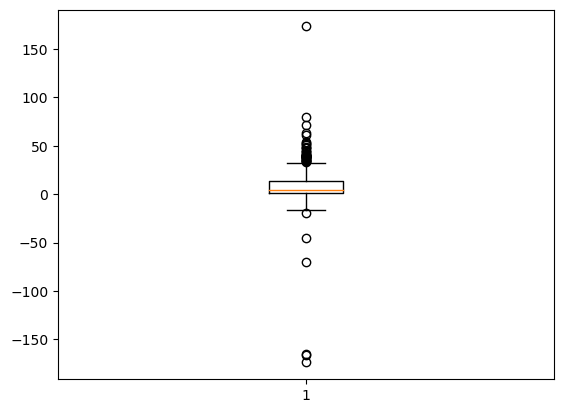

In [21]:
_ = plt.boxplot(t_vals)

In [24]:
sort_index = np.argsort(t_vals)
sorted_features = [features[idx] for idx in sort_index]

print(sorted_features[:10])
print(sorted_features[-10:])

['First_DM_Day', 'start_year', 'Second_DM_Day', 'Last_DM_Day', 'dobyr', 'Vitamin_Deficiency', 'Obesity', 'Autism', 'Substance_Abuse', 'Anxiety_Phobic_Disorder']
['Non-Specific_Skin_Disorder', 'Benign_Colon_Neoplasm', 'Acute_Sinusitis', 'Cellulitis', 'Non-Specific_Gastrointestinal_Disorder', 'Non-Specific_Joint_Disorder', 'Acute_Bronchitis', 'Total_DM_Codes', 'Unique_DM_Visit_Days', 'Diff_1st_Last']


### 1. Linear Classifier 

In [1]:
from sklearn.linear_model import SGDClassifier as sgd_clf
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from tune_sklearn import TuneGridSearchCV

clf = sgd_clf(
              random_state=42,
              class_weight="balanced",
              n_jobs=-1,
              max_iter=500,
              shuffle=True,
              )

pipeline = Pipeline([('scaler', MaxAbsScaler()), ('linear_clf', clf)])
skf = StratifiedKFold(n_splits=3, shuffle=True)

#### 1.1 Logistic Regression 

In [5]:
alphas = np.linspace(1e-4, 2e-3, 10)
param_grid = {'linear_clf__alpha': alphas, 'linear_clf__loss': ["log_loss"]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=skf, scoring='roc_auc',n_jobs=-1,verbose=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("ROC_AUC:", grid_search.best_score_)


KeyboardInterrupt: 

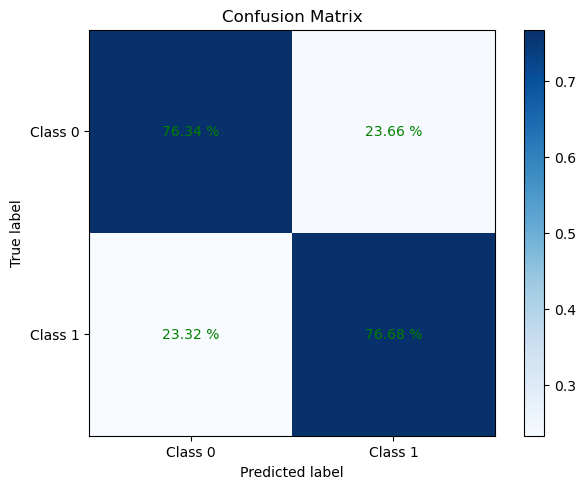

In [66]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
width, height = cm.shape

for x in range(width):
    for y in range(height):
        val = f"{cm[x][y] * 100:.2f} %"
        plt.annotate(val, xy=(y, x), 
                horizontalalignment='center',
                verticalalignment='center',
                color="green")